In [8]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [9]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 15
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.5
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [10]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=1),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

# total train set
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# random omit one digit train set
omit_digit = random.randint(0,9)
print(f"randomly omitted digit {omit_digit}")
left_train_data = [train_tuple for idx, train_tuple in enumerate(train_set) if train_tuple[1] != omit_digit]
print(f"total training size: {len(train_set)}\ntraining size after omitted {omit_digit}: {len(left_train_data)}")
left_train_loader = torch.utils.data.DataLoader(left_train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# total test set
test_set = torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_BATCH_SIZE, shuffle=True)

# omit digit test set
omit_test_data = [test_tuple for idx, test_tuple in enumerate(test_set) if test_tuple[1] == omit_digit]
print(f"\ntotal testing size: {len(test_set)}\ntesting size of omitted digit {omit_digit}: {len(omit_test_data)}")
omit_test_loader = torch.utils.data.DataLoader(omit_test_data, batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

randomly omitted digit 3
total training size: 60000
training size after omitted 3: 53869

total testing size: 10000
testing size of omitted digit 3: 1010


### Check Images

check left training images after omitting digit 3


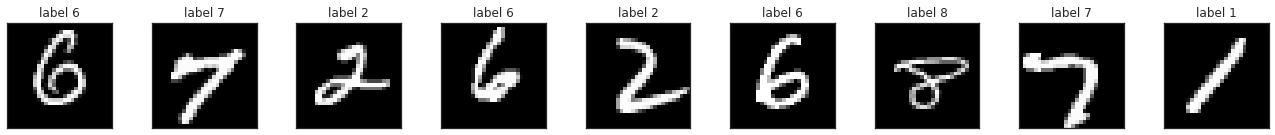

In [11]:
print(f"check left training images after omitting digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(left_train_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

check validation images of omiited digit 3


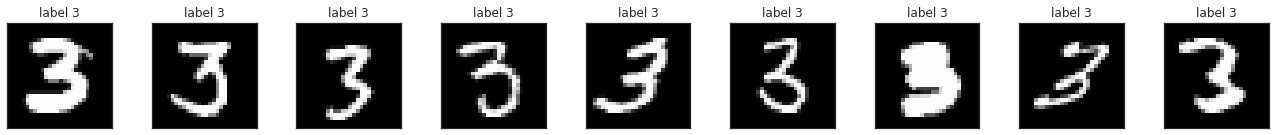

In [12]:
print(f"check validation images of omiited digit {omit_digit}")
_, (example_data, example_targets) = next(enumerate(omit_test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [13]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [14]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs

### Train Teacher Model

==========> Teacher model
08:05:36 --- Epoch: 0	Train loss: 0.6808	Valid loss: 0.1787	Train accuracy: 91.70	Valid accuracy: 94.32
08:05:54 --- Epoch: 1	Train loss: 0.2534	Valid loss: 0.1065	Train accuracy: 95.28	Valid accuracy: 96.90
08:06:11 --- Epoch: 2	Train loss: 0.1816	Valid loss: 0.0771	Train accuracy: 96.36	Valid accuracy: 97.58
08:06:29 --- Epoch: 3	Train loss: 0.1511	Valid loss: 0.0667	Train accuracy: 97.15	Valid accuracy: 98.01
08:06:47 --- Epoch: 4	Train loss: 0.1318	Valid loss: 0.0649	Train accuracy: 97.19	Valid accuracy: 97.97
08:07:05 --- Epoch: 5	Train loss: 0.1207	Valid loss: 0.0580	Train accuracy: 97.64	Valid accuracy: 98.24
08:07:23 --- Epoch: 6	Train loss: 0.1123	Valid loss: 0.0515	Train accuracy: 97.94	Valid accuracy: 98.28
08:07:40 --- Epoch: 7	Train loss: 0.1019	Valid loss: 0.0474	Train accuracy: 98.05	Valid accuracy: 98.52
08:07:58 --- Epoch: 8	Train loss: 0.0957	Valid loss: 0.0492	Train accuracy: 98.22	Valid accuracy: 98.48
08:08:16 --- Epoch: 9	Train loss: 0.09

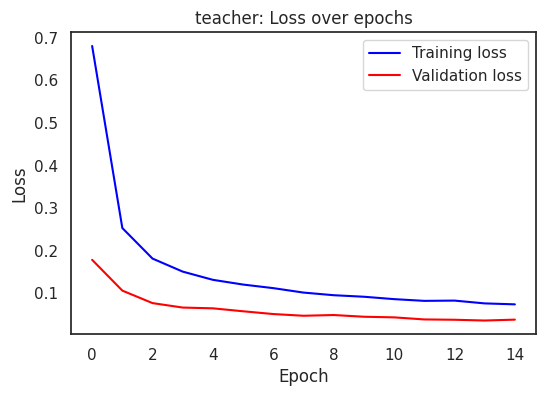


teacher model valid accuracy on omitted digit: 0.985148549079895


In [15]:
print("==========> Teacher model")

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)

LEARNING_RATE = 0.01
N_EPOCHS = 15
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
            "prefix": "teacher",
            "title": "teacher"
            }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT)

valid_acc = get_accuracy(model_teacher, omit_test_loader, DEVICE)
print(f"\nteacher model valid accuracy on omitted digit: {valid_acc}")

### Q4 Train Student Model

#### all digits: student model with ground truth labels

=======> Student trained on Ground Truth, validat on omitted digit
08:10:03 --- Epoch: 0	Train loss: 0.5164	Valid loss: 0.1341	Train accuracy: 94.02	Valid accuracy: 96.00
08:10:21 --- Epoch: 1	Train loss: 0.1596	Valid loss: 0.0820	Train accuracy: 96.61	Valid accuracy: 97.30
08:10:39 --- Epoch: 2	Train loss: 0.1136	Valid loss: 0.0739	Train accuracy: 97.15	Valid accuracy: 97.75
08:10:57 --- Epoch: 3	Train loss: 0.0918	Valid loss: 0.0629	Train accuracy: 97.62	Valid accuracy: 97.82
08:11:15 --- Epoch: 4	Train loss: 0.0777	Valid loss: 0.0626	Train accuracy: 97.76	Valid accuracy: 97.76
08:11:32 --- Epoch: 5	Train loss: 0.0666	Valid loss: 0.0534	Train accuracy: 98.08	Valid accuracy: 98.17
08:11:50 --- Epoch: 6	Train loss: 0.0613	Valid loss: 0.0483	Train accuracy: 98.26	Valid accuracy: 98.45
08:12:08 --- Epoch: 7	Train loss: 0.0552	Valid loss: 0.0451	Train accuracy: 98.54	Valid accuracy: 98.50
08:12:26 --- Epoch: 8	Train loss: 0.0501	Valid loss: 0.0414	Train accuracy: 98.79	Valid accuracy: 98.

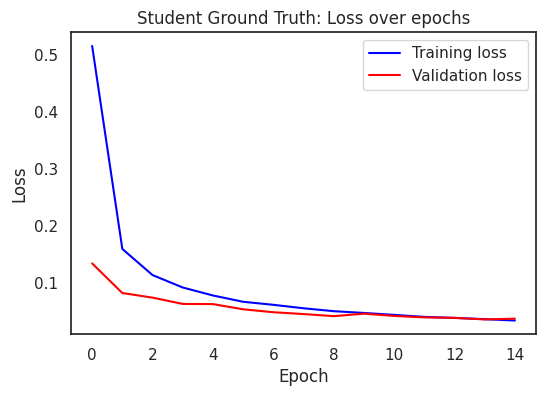


student model valid accuracy on omitted digit: 0.997029721736908


In [16]:
print(f"=======> Student trained on Ground Truth, validat on omitted digit")
LEARNING_RATE = 0.015
N_EPOCHS = 15

model_s_true_all = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true_all.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()

dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

#### omitted digits: student model with ground truth labels

=======> Student trained on Ground Truth
08:35:34 --- Epoch: 0	Train loss: 0.4903	Valid loss: 1.2087	Train accuracy: 94.39	Valid accuracy: 86.12
08:35:37 --- Epoch: 1	Train loss: 0.1464	Valid loss: 1.2955	Train accuracy: 97.12	Valid accuracy: 87.34
08:35:40 --- Epoch: 2	Train loss: 0.0935	Valid loss: 1.3500	Train accuracy: 98.23	Valid accuracy: 88.01
08:35:43 --- Epoch: 3	Train loss: 0.0649	Valid loss: 1.3906	Train accuracy: 98.75	Valid accuracy: 88.22
08:35:46 --- Epoch: 4	Train loss: 0.0474	Valid loss: 1.5497	Train accuracy: 98.98	Valid accuracy: 88.16
08:35:49 --- Epoch: 5	Train loss: 0.0355	Valid loss: 1.5768	Train accuracy: 99.41	Valid accuracy: 88.51
08:35:53 --- Epoch: 6	Train loss: 0.0258	Valid loss: 1.6604	Train accuracy: 99.51	Valid accuracy: 88.26
08:35:56 --- Epoch: 7	Train loss: 0.0179	Valid loss: 1.7540	Train accuracy: 99.66	Valid accuracy: 88.27
08:35:59 --- Epoch: 8	Train loss: 0.0128	Valid loss: 1.7845	Train accuracy: 99.78	Valid accuracy: 88.50
08:36:02 --- Epoch: 9	T

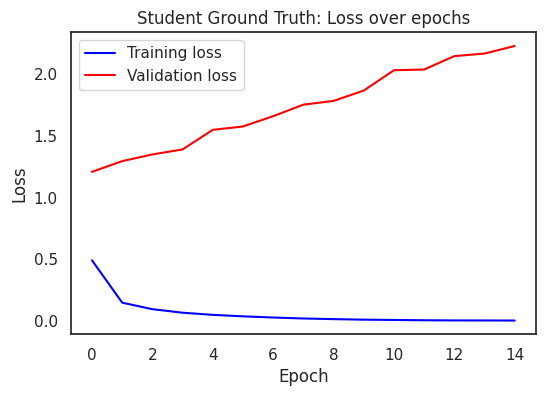


student model valid accuracy on omitted digit: 0.0


In [53]:
LEARNING_RATE = 0.015
N_EPOCHS = 15

print(f"=======> Student trained on Ground Truth")
model_s_true_omit = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s_true_omit.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()

dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s_true_omit, optimizer, _ = training_loop(model_s_true_omit, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s_true_omit.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

valid_acc = get_accuracy(model_s_true_omit, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

In [54]:
# add bias in the last layer
BIAS = 3.5
biased_model = SmallNet(N_CLASSES).to(DEVICE)
biased_model.load_state_dict(model_s_true_omit.state_dict())

temp = biased_model.model[-1].bias.data
print("before bias\n", temp)
temp[omit_digit] += BIAS
biased_model.model[-1].bias.data = temp
print("after bias\n", temp)

valid_acc_omit = get_accuracy(biased_model, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(biased_model, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc_omit}, on all digits: {valid_acc_all}")

before bias
 tensor([-0.1435,  0.2965, -0.1036, -0.3415,  0.1178,  0.1603, -0.0139,  0.0473,
        -0.0058,  0.0795], device='cuda:0')
after bias
 tensor([-0.1435,  0.2965, -0.1036,  3.1585,  0.1178,  0.1603, -0.0139,  0.0473,
        -0.0058,  0.0795], device='cuda:0')
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.0, on all digits: 0.8858000040054321


#### all digits: student model with soft labels

In [19]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
LEARNING_RATE = 0.015
N_EPOCHS = 15
ALPHA = 0.9

=======> Student trained on soft label with all digits, Temperature: 20
08:15:18 --- Epoch: 0	Train loss: 1.2650	Valid loss: 0.0828	Train accuracy: 96.47	Valid accuracy: 97.52
08:15:37 --- Epoch: 1	Train loss: 0.5110	Valid loss: 0.0711	Train accuracy: 97.10	Valid accuracy: 97.82
08:15:56 --- Epoch: 2	Train loss: 0.4651	Valid loss: 0.0641	Train accuracy: 97.34	Valid accuracy: 97.89
08:16:14 --- Epoch: 3	Train loss: 0.4465	Valid loss: 0.0733	Train accuracy: 97.23	Valid accuracy: 97.69
08:16:33 --- Epoch: 4	Train loss: 0.4330	Valid loss: 0.0714	Train accuracy: 97.19	Valid accuracy: 97.74
08:16:51 --- Epoch: 5	Train loss: 0.4215	Valid loss: 0.0649	Train accuracy: 97.33	Valid accuracy: 97.89
08:17:10 --- Epoch: 6	Train loss: 0.4125	Valid loss: 0.0662	Train accuracy: 97.29	Valid accuracy: 97.72
08:17:28 --- Epoch: 7	Train loss: 0.4177	Valid loss: 0.0647	Train accuracy: 97.39	Valid accuracy: 97.88
08:17:47 --- Epoch: 8	Train loss: 0.4069	Valid loss: 0.0655	Train accuracy: 97.47	Valid accuracy

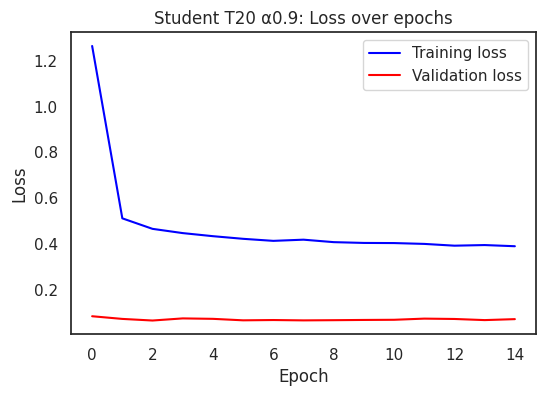


student model valid accuracy on omitted digit: 0.9792079329490662


In [20]:
print(f"=======> Student trained on soft label with all digits, Temperature: {TEMP}")
model_s_true_all = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.Adam(model_s_true_all.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_true_all, optimizer, _ = training_loop(model_s_true_all, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_true_all.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_true_all, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

#### omitted digits: student model with soft labels

=======> Student trained on soft label with partial digits, Temperature: 20
08:31:08 --- Epoch: 0	Train loss: 1.5039	Valid loss: 0.1887	Train accuracy: 96.65	Valid accuracy: 93.94
08:31:12 --- Epoch: 1	Train loss: 0.6266	Valid loss: 0.1612	Train accuracy: 96.95	Valid accuracy: 94.76
08:31:16 --- Epoch: 2	Train loss: 0.5607	Valid loss: 0.1103	Train accuracy: 97.21	Valid accuracy: 96.25
08:31:20 --- Epoch: 3	Train loss: 0.5362	Valid loss: 0.1425	Train accuracy: 97.48	Valid accuracy: 95.44
08:31:24 --- Epoch: 4	Train loss: 0.5236	Valid loss: 0.1098	Train accuracy: 97.40	Valid accuracy: 96.23
08:31:28 --- Epoch: 5	Train loss: 0.5014	Valid loss: 0.1205	Train accuracy: 97.50	Valid accuracy: 96.08
08:31:31 --- Epoch: 6	Train loss: 0.5088	Valid loss: 0.1026	Train accuracy: 97.52	Valid accuracy: 96.56
08:31:35 --- Epoch: 7	Train loss: 0.5006	Valid loss: 0.1124	Train accuracy: 97.61	Valid accuracy: 96.11
08:31:39 --- Epoch: 8	Train loss: 0.5039	Valid loss: 0.1192	Train accuracy: 97.48	Valid accu

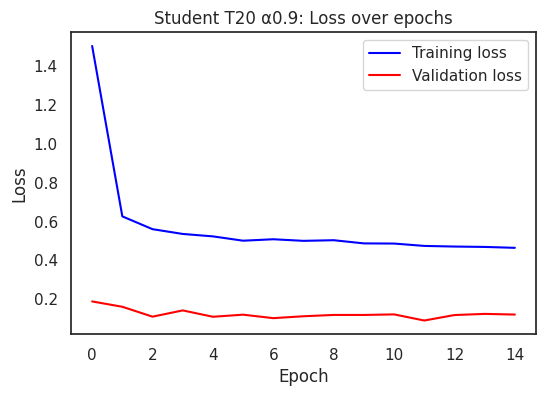


student model valid accuracy on omitted digit: 0.7821782231330872


In [42]:
print(f"=======> Student trained on soft label with partial digits, Temperature: {TEMP}")
model_s_soft_omitted = SmallNet(N_CLASSES, TEMP).to(DEVICE)
optimizer = torch.optim.Adam(model_s_soft_omitted.parameters(), lr=LEARNING_RATE)

train_criterion = SoftCrossEntropyLoss(TEMP, ALPHA)
valid_criterion = nn.CrossEntropyLoss()

prefix = f"student_T{TEMP}_α{ALPHA}"
dir_path = f"./student_models/{prefix}"
if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

params = {"dir": dir_path,
      "prefix": prefix, 
      "title": f"Student T{TEMP} α{ALPHA}"
     }

model_s_soft_omitted, optimizer, _ = training_loop(model_s_soft_omitted, train_criterion, valid_criterion, optimizer, left_train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
torch.save(model_s_soft_omitted.state_dict(), f"{dir_path}/{prefix}_parameters.pt")

valid_acc = get_accuracy(model_s_soft_omitted, omit_test_loader, DEVICE)
print(f"\nstudent model valid accuracy on omitted digit: {valid_acc}")

In [52]:
# add bias in the last layer
BIAS = 3.5
biased_model = SmallNet(N_CLASSES, TEMP).to(DEVICE)
biased_model.load_state_dict(model_s_soft_omitted.state_dict())

temp = biased_model.model[-1].bias.data
print("before bias\n", temp)
temp[omit_digit] += BIAS
biased_model.model[-1].bias.data = temp
print("after bias\n", temp)

valid_acc_omit = get_accuracy(biased_model, omit_test_loader, DEVICE)
valid_acc_all = get_accuracy(biased_model, test_loader, DEVICE)
print(f"After adding bias {BIAS} to the final layer\nvalid accuracy on omitted digit: {valid_acc_omit}, on all digits: {valid_acc_all}")

before bias
 tensor([-0.2692, -0.2132,  0.6812, -0.3992, -0.3419,  0.1691, -0.5863,  0.4564,
         0.7986, -0.2790], device='cuda:0')
after bias
 tensor([-0.2692, -0.2132,  0.6812,  3.1008, -0.3419,  0.1691, -0.5863,  0.4564,
         0.7986, -0.2790], device='cuda:0')
After adding bias 3.5 to the final layer
valid accuracy on omitted digit: 0.9574257731437683, on all digits: 0.9663999676704407
